In [1]:
from pandas import read_csv
import pandas as pd
import numpy as np
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font
os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync/')


In [22]:
analysis_year = 2050
scenario_definition = read_csv('Parameter/opcost_sensitivity_analysis.csv', encoding='utf-8')
list_of_sc = scenario_definition['Scenario_ID'].unique()
# scenario_definition.head(5)
print(list_of_sc)

vehicle_type_by_state = read_csv('inputs/fleet/fleet_composition_by_state.csv')
list_of_veh_tech = vehicle_type_by_state['vehicle category'].unique().tolist()
print(list_of_veh_tech)
print(scenario_definition.columns)
scenario_definition_short = \
scenario_definition[['Scenario_ID', 'Diesel_Scenario', 'Elec_Scenario', 'Elec price ($/hWh)']]

scenario_definition_short.head(5)

['HOP_highp2' 'HOP_highp4' 'HOP_highp6' 'HOP_highp8' 'HOP_highp10'
 'Ref_highp2' 'Ref_highp4' 'Ref_highp6' 'Ref_highp8' 'Ref_highp10']
['Diesel Class 4-6 Vocational', 'Electric Class 4-6 Vocational', 'Gasoline Class 4-6 Vocational', 'Diesel Class 7&8 Tractor', 'Electric Class 7&8 Tractor', 'Diesel Class 7&8 Vocational', 'Electric Class 7&8 Vocational']
Index(['Scenario_ID', 'Diesel_Scenario', 'Elec_Scenario', 'Fuel price ($/gal)',
       'Elec price ($/hWh)', 'Elec_FC', 'Diesel_FC', 'NFC', 'Elec_TC',
       'Diesel_TC', 'Rail_TC'],
      dtype='object')


,Scenario_ID,Diesel_Scenario,Elec_Scenario,Elec price ($/hWh)
0,HOP_highp2,HOP,p2,0.14
1,HOP_highp4,HOP,p4,0.19
2,HOP_highp6,HOP,p6,0.23
3,HOP_highp8,HOP,p8,0.28
4,HOP_highp10,HOP,p10,0.33


In [3]:
def get_veh_count(data):
    out_fleet = {}
    out_fleet['BEV Class 4-6 Vocational'] = \
    data.loc[data['EV_powertrain (if any)'] == 'Battery Electric', 'Electric Class 4-6 Vocational'].sum()
    out_fleet['BEV Class 7&8 Vocational'] = \
    data.loc[data['EV_powertrain (if any)'] == 'Battery Electric', 'Electric Class 7&8 Vocational'].sum()
    out_fleet['BEV Class 7&8 Tractor'] = \
    data.loc[data['EV_powertrain (if any)'] == 'Battery Electric', 'Electric Class 7&8 Tractor'].sum()
    
    out_fleet['PHEV Class 4-6 Vocational'] = \
    data.loc[data['EV_powertrain (if any)'] == 'PHEV', 'Electric Class 4-6 Vocational'].sum()
    out_fleet['PHEV Class 7&8 Vocational'] = \
    data.loc[data['EV_powertrain (if any)'] == 'PHEV', 'Electric Class 7&8 Vocational'].sum()        
    out_fleet['PHEV Class 7&8 Tractor'] = \
    data.loc[data['EV_powertrain (if any)'] == 'PHEV', 'Electric Class 7&8 Tractor'].sum()
    
    out_fleet['H2FC Class 4-6 Vocational'] = \
    data.loc[data['EV_powertrain (if any)'] == 'H2 Fuel Cell', 'Electric Class 4-6 Vocational'].sum()
    out_fleet['H2FC Class 7&8 Vocational'] = \
    data.loc[data['EV_powertrain (if any)'] == 'H2 Fuel Cell', 'Electric Class 7&8 Vocational'].sum()
    out_fleet['H2FC Class 7&8 Tractor'] = \
    data.loc[data['EV_powertrain (if any)'] == 'H2 Fuel Cell', 'Electric Class 7&8 Tractor'].sum()
    
    out_fleet['Diesel Class 4-6 Vocational'] = data.loc[:, 'Diesel Class 4-6 Vocational'].sum() \
    + data.loc[:, 'Gasoline Class 4-6 Vocational'].sum()
    out_fleet['Diesel Class 7&8 Vocational'] = data.loc[:, 'Diesel Class 7&8 Vocational'].sum()
    out_fleet['Diesel Class 7&8 Tractor'] = data.loc[:, 'Diesel Class 7&8 Tractor'].sum()
    out_fleet_df = pd.DataFrame.from_dict(out_fleet, orient='index')
    out_fleet_df = out_fleet_df.reset_index()
    out_fleet_df.columns = ['vehicle type', 'count']
    return(out_fleet_df)
    

In [4]:
out_fleet_mix = None
for sc in list_of_sc:
    print('processing scenario ' + sc)
    input_path = 'outputs_aus_fleet/' + str(analysis_year) + '/' + \
    sc + '/' + 'firms_and_fleet/'
    
#     for sc in list_of_scenarios:
#         print(year, sc)
    firm_file = 'synthetic_firms_with_fleet_mc_adjusted.csv'
    carrier_file = 'synthetic_carriers.csv'
    lease_file = 'synthetic_leasing_company.csv'
    firms_with_fleet = read_csv(input_path + firm_file)
    carriers_with_fleet = read_csv(input_path + carrier_file)
    leasing_with_fleet = read_csv(input_path + lease_file)

    # select Austin only
    aus_zone = [481, 488, 489]
    firms_with_fleet = firms_with_fleet.loc[firms_with_fleet['FAFZONE'].isin(aus_zone)]
    carriers_with_fleet = carriers_with_fleet.loc[carriers_with_fleet['FAFZONE'].isin(aus_zone)]
    leasing_with_fleet = leasing_with_fleet.loc[leasing_with_fleet['FAFZONE'].isin(aus_zone)]
#         firms_with_fleet.head(5)
    firm_fleet_agg = get_veh_count(firms_with_fleet)
    firm_fleet_agg.loc[:, 'source'] = 'firms'
    carrier_fleet_agg = get_veh_count(carriers_with_fleet)
    carrier_fleet_agg.loc[:, 'source'] = 'carrier'
    lease_fleet_agg = get_veh_count(leasing_with_fleet)
    lease_fleet_agg.loc[:, 'source'] = 'lease'

#         firm_fleet_agg = firms_with_fleet.loc[:, list_of_veh_tech].sum()
#         firm_fleet_agg = firm_fleet_agg.to_frame()
#         firm_fleet_agg = firm_fleet_agg.reset_index()
#         firm_fleet_agg.columns = ['vehicle_type', 'total']



#         carrier_fleet_agg = carriers_with_fleet.loc[:, list_of_veh_tech].sum()
#         carrier_fleet_agg = carrier_fleet_agg.to_frame()
#         carrier_fleet_agg = carrier_fleet_agg.reset_index()
#         carrier_fleet_agg.columns = ['vehicle_type', 'total']
#         carrier_fleet_agg.loc[:, 'source'] = 'carrier'

#         lease_fleet_agg = leasing_with_fleet.loc[:, list_of_veh_tech].sum()
#         lease_fleet_agg = lease_fleet_agg.to_frame()
#         lease_fleet_agg = lease_fleet_agg.reset_index()
#         lease_fleet_agg.columns = ['vehicle_type', 'total']
#         lease_fleet_agg.loc[:, 'source'] = 'lease'

    all_fleet_agg = pd.concat([firm_fleet_agg, carrier_fleet_agg, lease_fleet_agg])
#     all_fleet_agg.loc[:, 'year'] = year
    all_fleet_agg.loc[:, 'scenario'] = sc
    out_fleet_mix = pd.concat([out_fleet_mix, all_fleet_agg])
    
#         break
#     break
out_fleet_mix.head(5)
# out_fleet_mix.head(5)

processing scenario HOP_highp2
processing scenario HOP_highp4
processing scenario HOP_highp6
processing scenario HOP_highp8
processing scenario HOP_highp10
processing scenario Ref_highp2
processing scenario Ref_highp4
processing scenario Ref_highp6
processing scenario Ref_highp8
processing scenario Ref_highp10


,vehicle type,count,source,scenario
0,BEV Class 4-6 Vocational,55240.0,firms,HOP_highp2
1,BEV Class 7&8 Vocational,21314.0,firms,HOP_highp2
2,BEV Class 7&8 Tractor,39346.0,firms,HOP_highp2
3,PHEV Class 4-6 Vocational,608.0,firms,HOP_highp2
4,PHEV Class 7&8 Vocational,246.0,firms,HOP_highp2


In [5]:
print(firms_with_fleet.FAFZONE.unique())

[489 488 481]


In [7]:
# generate fleet composition by fraction
# print(out_fleet_mix.vehicle_type.unique())
out_fleet_mix_agg = \
out_fleet_mix.groupby(['vehicle type', 'scenario'])[['count']].sum()
out_fleet_mix_agg = out_fleet_mix_agg.reset_index()
# out_fleet_mix.loc[out_fleet_mix['vehicle typ'] == 'Gasoline Class 4-6 Vocational', 'vehicle_type'] = 'Diesel Class 4-6 Vocational'
# out_fleet_mix_agg.loc[:, 'Case'] = out_fleet_mix_agg.loc[:, 'year'].astype(str) + ' ' + out_fleet_mix_agg.loc[:, 'scenario']
out_fleet_mix_agg.loc[:, 'fraction'] = out_fleet_mix_agg.loc[:, 'count'] / out_fleet_mix_agg.groupby(['scenario'])['count'].transform('sum')
out_fleet_mix_agg.head(10)

,vehicle type,scenario,count,fraction
0,BEV Class 4-6 Vocational,HOP_highp10,34401.0,0.104258
1,BEV Class 4-6 Vocational,HOP_highp2,56876.0,0.171991
2,BEV Class 4-6 Vocational,HOP_highp4,46566.0,0.142732
3,BEV Class 4-6 Vocational,HOP_highp6,45466.0,0.140725
4,BEV Class 4-6 Vocational,HOP_highp8,41340.0,0.129915
5,BEV Class 4-6 Vocational,Ref_highp10,22412.0,0.066905
6,BEV Class 4-6 Vocational,Ref_highp2,50215.0,0.152263
7,BEV Class 4-6 Vocational,Ref_highp4,42273.0,0.127923
8,BEV Class 4-6 Vocational,Ref_highp6,35131.0,0.107407
9,BEV Class 4-6 Vocational,Ref_highp8,29677.0,0.091867


In [10]:
# out_fleet_mix_to_plot = \
# out_fleet_mix_agg.loc[out_fleet_mix_agg['Case'].isin(['2030 TDA_low', '2050 TDA_central', '2050 TDA_high'])]
# out_fleet_mix_to_plot.loc[out_fleet_mix_to_plot['Case'] == '2030 TDA_low', 'Case'] = 'Base'
# out_fleet_mix_to_plot.loc[out_fleet_mix_to_plot['Case'] == '2050 TDA_central', 'Case'] = 'Central tech'
# out_fleet_mix_to_plot.loc[out_fleet_mix_to_plot['Case'] == '2050 TDA_high', 'Case'] = 'High tech'
# out_fleet_mix_to_plot.head(5)

,vehicle type,year,scenario,count,Case,fraction
2,BEV Class 4-6 Vocational,2030,TDA_low,0,Base,0.000000
6,BEV Class 4-6 Vocational,2050,TDA_central,13686,Central tech,0.054530
7,BEV Class 4-6 Vocational,2050,TDA_high,24810,High tech,0.120905
11,BEV Class 7&8 Tractor,2030,TDA_low,0,Base,0.000000
15,BEV Class 7&8 Tractor,2050,TDA_central,74,Central tech,0.000295


In [8]:
print(out_fleet_mix_agg['vehicle type'].unique())

['BEV Class 4-6 Vocational' 'BEV Class 7&8 Tractor'
 'BEV Class 7&8 Vocational' 'Diesel Class 4-6 Vocational'
 'Diesel Class 7&8 Tractor' 'Diesel Class 7&8 Vocational'
 'H2FC Class 4-6 Vocational' 'H2FC Class 7&8 Tractor'
 'H2FC Class 7&8 Vocational' 'PHEV Class 4-6 Vocational'
 'PHEV Class 7&8 Tractor' 'PHEV Class 7&8 Vocational']


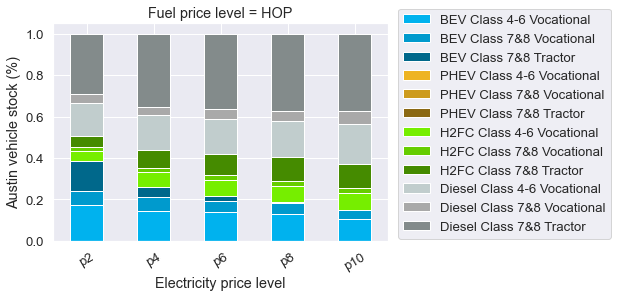

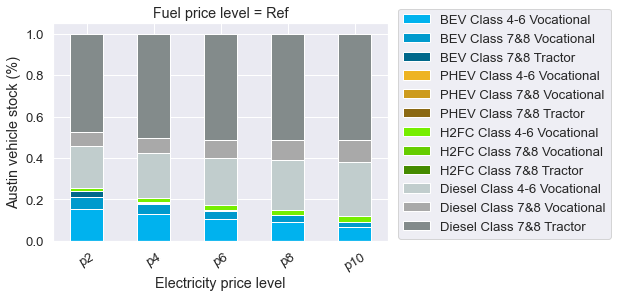

In [26]:
# out_fleet_mix_to_plot.loc[:, 'fraction'] *= 100
# level_map = {'BEV Class 4-6 Vocational': 1, 
#              'BEV Class 7&8 Vocational': 2,
#              'BEV Class 7&8 Tractor': 3,
#              'PHEV Class 4-6 Vocational': 4, 
#              'PHEV Class 7&8 Vocational': 5,  
#              'PHEV Class 7&8 Tractor': 6, 
#              'H2FC Class 4-6 Vocational': 7, 
#              'H2FC Class 7&8 Vocational': 8, 
#              'H2FC Class 7&8 Tractor': 9, 
#              'Diesel Class 4-6 Vocational': 10, 
#              'Diesel Class 7&8 Vocational': 11,
#              'Diesel Class 7&8 Tractor': 12 
# }
# out_fleet_mix_to_plot.loc[:, 'level'] = \
# out_fleet_mix_to_plot.loc[:, 'vehicle type'].map(level_map)
# out_fleet_mix_to_plot = out_fleet_mix_to_plot.sort_values(by = 'level')
# out_fleet_mix_to_plot = out_fleet_mix_to_plot.drop(columns='level')

combined_fleet_to_plot = \
pd.pivot_table(out_fleet_mix_agg,
               values='fraction', 
               index=['scenario'],
               columns=['vehicle type'], 
               aggfunc=np.sum, sort = False)
combined_fleet_to_plot = combined_fleet_to_plot.reset_index()
combined_fleet_to_plot = combined_fleet_to_plot[['scenario',
                                                 'BEV Class 4-6 Vocational', 
                                                 'BEV Class 7&8 Vocational',
                                                 'BEV Class 7&8 Tractor',
                                                 'PHEV Class 4-6 Vocational', 
                                                 'PHEV Class 7&8 Vocational',  
                                                 'PHEV Class 7&8 Tractor', 
                                                 'H2FC Class 4-6 Vocational', 
                                                 'H2FC Class 7&8 Vocational', 
                                                 'H2FC Class 7&8 Tractor', 
                                                 'Diesel Class 4-6 Vocational', 
                                                 'Diesel Class 7&8 Vocational',
                                                 'Diesel Class 7&8 Tractor']]
colors = ["#00b2ee", "#009acd", "#00688b", # the blues   
          "#eeb422", "#cd9b1d", "#8b6914", # the golds
          "#76ee00", "#66cd00", "#458b00", # the greens
          "#c1cdcd", "#a9a9a9", "#838b8b"] # the greys
          
combined_fleet_to_plot = pd.merge(combined_fleet_to_plot,
                                  scenario_definition_short,
                                  left_on = 'scenario',
                                  right_on = 'Scenario_ID',
                                  how = 'left')
combined_fleet_to_plot = \
combined_fleet_to_plot.sort_values(by = 'Elec price ($/hWh)')


combined_fleet_to_plot = \
combined_fleet_to_plot.drop(columns = ['scenario', 'Scenario_ID', 'Elec price ($/hWh)'])
# customPalette = sns.set_palette(sns.color_palette(colors))
# combined_fleet_to_plot.loc[:, 'penetration_level'] = \
# combined_fleet_to_plot.loc[:, 'scenario'].map(level_map)
# combined_fleet_to_plot = combined_fleet_to_plot.sort_values(by = 'penetration_level')
# combined_fleet_to_plot = combined_fleet_to_plot.drop(columns='penetration_level')
diesel_scenario = combined_fleet_to_plot.Diesel_Scenario.unique()
combined_fleet_to_plot.to_csv('outputs_aus_fleet/fleet_composition_cost_sensitivity.csv', index = False)
for ds in diesel_scenario:
    combined_fleet_selected = \
    combined_fleet_to_plot.loc[combined_fleet_to_plot['Diesel_Scenario'] == ds]
    combined_fleet_selected.plot.bar(x= 'Elec_Scenario', 
                                    stacked=True, color = colors)
    plt.xticks(rotation = 30)
    plt.legend(bbox_to_anchor=(1.01, -0.02), loc='lower left')
    plt.ylabel('Austin vehicle stock (%)')
    plt.xlabel('Electricity price level')
    plt.title('Fuel price level = ' + ds)
    plt.savefig('outputs_aus_fleet/fleet_composition_' + ds + '_austin_SA.png', dpi = 300, bbox_inches = 'tight')